## initial setup and download

### Dataset download

In [1]:
#### training set

!wget -O train.zip "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip"
!unzip -q train.zip
!rm -r train.zip

!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip"
!unzip -q ISIC2018_Task1_Training_GroundTruth.zip
!rm -r ISIC2018_Task1_Training_GroundTruth.zip

--2024-11-08 01:49:01--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.203.137, 52.216.94.131, 16.182.101.241, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.203.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11165358566 (10G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]  10.40G  31.7MB/s    in 5m 41s  

2024-11-08 01:54:42 (31.3 MB/s) - ‘train.zip’ saved [11165358566/11165358566]

--2024-11-08 01:57:00--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.233.193, 52.216.152.172, 3.5.29.203, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.2

In [2]:
!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip"
!unzip -q ISIC2018_Task1-2_Validation_Input.zip
!rm -r ISIC2018_Task1-2_Validation_Input.zip

!wget "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip"
!unzip -q ISIC2018_Task1_Validation_GroundTruth.zip
!rm -r ISIC2018_Task1_Validation_GroundTruth.zip

--2024-11-08 01:57:47--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.28.88, 54.231.136.41, 3.5.12.95, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239231159 (228M) [application/zip]
Saving to: ‘ISIC2018_Task1-2_Validation_Input.zip’

ISIC2018_Task1-2_Va 100%[===================>] 228.15M  47.3MB/s    in 5.2s    

2024-11-08 01:57:52 (43.8 MB/s) - ‘ISIC2018_Task1-2_Validation_Input.zip’ saved [239231159/239231159]

--2024-11-08 01:57:55--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.140.113, 54.231.137.201, 54.231.234.145, ...
Connecting to isic-challenge-data.s3.amazonaws.com (is

## Segmentation models

### UNet

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [4]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
# U-Net model definition
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder path
        self.enc_conv1 = self.conv_block(3, 64)
        self.enc_conv2 = self.conv_block(64, 128)
        self.enc_conv3 = self.conv_block(128, 256)
        self.enc_conv4 = self.conv_block(256, 512)

        # Bridge
        self.bridge = self.conv_block(512, 1024)

        # Decoder path
        self.upconv4 = self.upconv_block(1024, 512)
        self.dec_conv4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv_block(512, 256)
        self.dec_conv3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv_block(256, 128)
        self.dec_conv2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv_block(128, 64)
        self.dec_conv1 = self.conv_block(128, 64)

        # Final layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(nn.functional.max_pool2d(enc1, 2))
        enc3 = self.enc_conv3(nn.functional.max_pool2d(enc2, 2))
        enc4 = self.enc_conv4(nn.functional.max_pool2d(enc3, 2))

        # Bridge
        bridge = self.bridge(nn.functional.max_pool2d(enc4, 2))

        # Decoder with concatenation
        dec4 = self.upconv4(bridge)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec_conv4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec_conv3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec_conv2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec_conv1(dec1)

        # Final output layer
        return torch.sigmoid(self.final_conv(dec1))

# Dataset class with error handling for missing files
class ISICDataset(Dataset):
    def __init__(self, img_filenames, mask_filenames, img_size=(256, 256)):
        self.img_filenames = img_filenames
        self.mask_filenames = mask_filenames
        self.img_size = img_size

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        # Load and preprocess image
        img = cv2.imread(self.img_filenames[idx])
        if img is None:
            raise FileNotFoundError(f"Image file {self.img_filenames[idx]} could not be loaded.")
        img = cv2.resize(img, self.img_size)
        img = img.transpose((2, 0, 1)) / 255.0  # Normalize and convert to channel-first format
        img = torch.tensor(img, dtype=torch.float32)

        # Load and preprocess mask
        mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask file {self.mask_filenames[idx]} could not be loaded.")
        mask = cv2.resize(mask, self.img_size)
        mask = np.expand_dims(mask, axis=0) / 255.0  # Normalize and add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask


# Load data
def load_filenames():
    train_img_filenames = sorted([os.path.join('ISIC2018_Task1-2_Training_Input', f) for f in os.listdir('ISIC2018_Task1-2_Training_Input') if f.endswith('.jpg')])
    train_mask_filenames = sorted([os.path.join('ISIC2018_Task1_Training_GroundTruth', f.split('/')[1].replace('.jpg', '_segmentation.png')) for f in train_img_filenames])
    val_img_filenames = sorted([os.path.join('ISIC2018_Task1-2_Validation_Input', f) for f in os.listdir('ISIC2018_Task1-2_Validation_Input') if f.endswith('.jpg')])
    val_mask_filenames = sorted([os.path.join('ISIC2018_Task1_Validation_GroundTruth', f.split('/')[1].replace('.jpg', '_segmentation.png')) for f in val_img_filenames])
    return train_img_filenames, train_mask_filenames,val_img_filenames,val_mask_filenames



In [6]:
train_img_filenames, train_mask_filenames,val_img_filenames,val_mask_filenames = load_filenames()

In [7]:
print(train_img_filenames[:10])

['ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000001.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000003.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000004.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000006.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000007.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000008.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000009.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000011.jpg', 'ISIC2018_Task1-2_Training_Input/ISIC_0000012.jpg']


In [8]:
print(train_mask_filenames[:10])

['ISIC2018_Task1_Training_GroundTruth/ISIC_0000000_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000001_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000003_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000004_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000006_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000007_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000008_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000009_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000011_segmentation.png', 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000012_segmentation.png']


In [9]:
train_dataset = ISICDataset(train_img_filenames, train_mask_filenames)
val_dataset = ISICDataset(val_img_filenames, val_mask_filenames)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [19]:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs by a factor of 0.1
criterion = nn.BCELoss()

In [20]:
# Function to load the model and optimizer states
def load_checkpoint(model, optimizer=None, checkpoint_path='best_model.pth'):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from '{checkpoint_path}'...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        if(optimizer):
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Checkpoint loaded successfully.")
    else:
        print(f"No checkpoint found at '{checkpoint_path}'")

In [21]:
load_checkpoint(model, optimizer, checkpoint_path='best_model.pth')

Loading checkpoint from 'best_model.pth'...


<ipython-input-20-2c2d4fa80e2f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


KeyError: 'model_state_dict'

In [22]:
# Load the best model checkpoint
def load_best_model(model, checkpoint_path='best_model.pth'):
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    print("Loaded model weights from", checkpoint_path)

In [23]:
# Example usage
model = UNet()  # Initialize the model
load_best_model(model, checkpoint_path='best_model.pth')

Loaded model weights from best_model.pth


<ipython-input-22-3c68428c5fc8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


In [24]:
# Modified training function to save model and optimizer state
def train_model(model, train_loader, val_loader, optimizer, scheduler=None, num_epochs=4, checkpoint_path='best_model.pth'):
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Save the model if the validation loss has improved
        if val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
            best_val_loss = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, checkpoint_path)

        # Step the learning rate scheduler
        if scheduler:
            scheduler.step()


In [26]:
train_model(model, train_loader, val_loader, optimizer, scheduler=scheduler, num_epochs=4,checkpoint_path='kaggle_best_model.pth')

Epoch 1/4: 100%|██████████| 82/82 [08:27<00:00,  6.19s/it]


Epoch 1, Training Loss: 0.3000
Validation Loss: 0.2980
Validation loss improved from inf to 0.2980. Saving model...


Epoch 2/4: 100%|██████████| 82/82 [08:27<00:00,  6.19s/it]


Epoch 2, Training Loss: 0.3000
Validation Loss: 0.2980


Epoch 3/4: 100%|██████████| 82/82 [08:25<00:00,  6.17s/it]


Epoch 3, Training Loss: 0.2994
Validation Loss: 0.2980


Epoch 4/4: 100%|██████████| 82/82 [08:20<00:00,  6.11s/it]


Epoch 4, Training Loss: 0.3048
Validation Loss: 0.2980


In [27]:
# Function to load the model and optimizer states
def load_checkpoint(model, optimizer=None, checkpoint_path='best_model.pth'):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from '{checkpoint_path}'...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        if(optimizer):
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Checkpoint loaded successfully.")
    else:
        print(f"No checkpoint found at '{checkpoint_path}'")

In [28]:
# Image segmentation and visualization without groundtruth mask
def segment_image(model, image_path, img_size=(256, 256)):
    model.eval()  # Set model to evaluation mode
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image file {image_path} could not be loaded.")

    # Resize and normalize the image for model input
    img_resized = cv2.resize(img, img_size)
    img_normalized = img_resized.transpose((2, 0, 1)) / 255.0  # Normalize and change to channel-first format
    img_input = torch.tensor(img_normalized, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension and send to GPU

    with torch.no_grad():
        # Perform prediction
        mask_pred = model(img_input)[0].cpu().numpy().squeeze()  # Move output to CPU and remove batch dimension

    # Threshold mask to create binary mask and resize to original image size
    mask_binary = (mask_pred > 0.5).astype(np.uint8)
    mask_resized = cv2.resize(mask_binary, (img.shape[1], img.shape[0]))  # Resize to original image size

    # Apply the resized mask to the original image
    segmented_img = img * mask_resized[..., np.newaxis]  # Broadcasting mask across color channels

    # Plot original, mask, and segmented image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask_resized, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Segmented Image")
    plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [29]:
# Image segmentation and visualization with ground truth mask
def segment_image(model, image_path, mask_path, img_size=(256, 256)):
    model.eval()  # Set model to evaluation mode

    # Load and preprocess the input image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image file {image_path} could not be loaded.")
    img_resized = cv2.resize(img, img_size)
    img_normalized = img_resized.transpose((2, 0, 1)) / 255.0  # Normalize and change to channel-first format
    img_input = torch.tensor(img_normalized, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension and send to GPU

    # Load the ground truth mask
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None:
        raise FileNotFoundError(f"Mask file {mask_path} could not be loaded.")
    gt_mask_resized = cv2.resize(gt_mask, (img.shape[1], img.shape[0]))  # Resize to original image size if needed

    # Model prediction
    with torch.no_grad():
        mask_pred = model(img_input)[0].cpu().numpy().squeeze()  # Move output to CPU and remove batch dimension

    # Process the predicted mask
    mask_binary = (mask_pred > 0.5).astype(np.uint8)
    mask_resized = cv2.resize(mask_binary, (img.shape[1], img.shape[0]))  # Resize to original image size

    # Apply the predicted mask to create a segmented image
    segmented_img = img * mask_resized[..., np.newaxis]  # Broadcasting mask across color channels

    # Plot the original image, ground truth mask, predicted mask, and segmented image
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask_resized, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("Predicted Mask")
    plt.imshow(mask_resized, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Segmented Image")
    plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [30]:
image_path = 'ISIC2018_Task1-2_Training_Input/ISIC_0000015.jpg'  # Replace with actual image path
segment_image(model, image_path)

TypeError: segment_image() missing 1 required positional argument: 'mask_path'

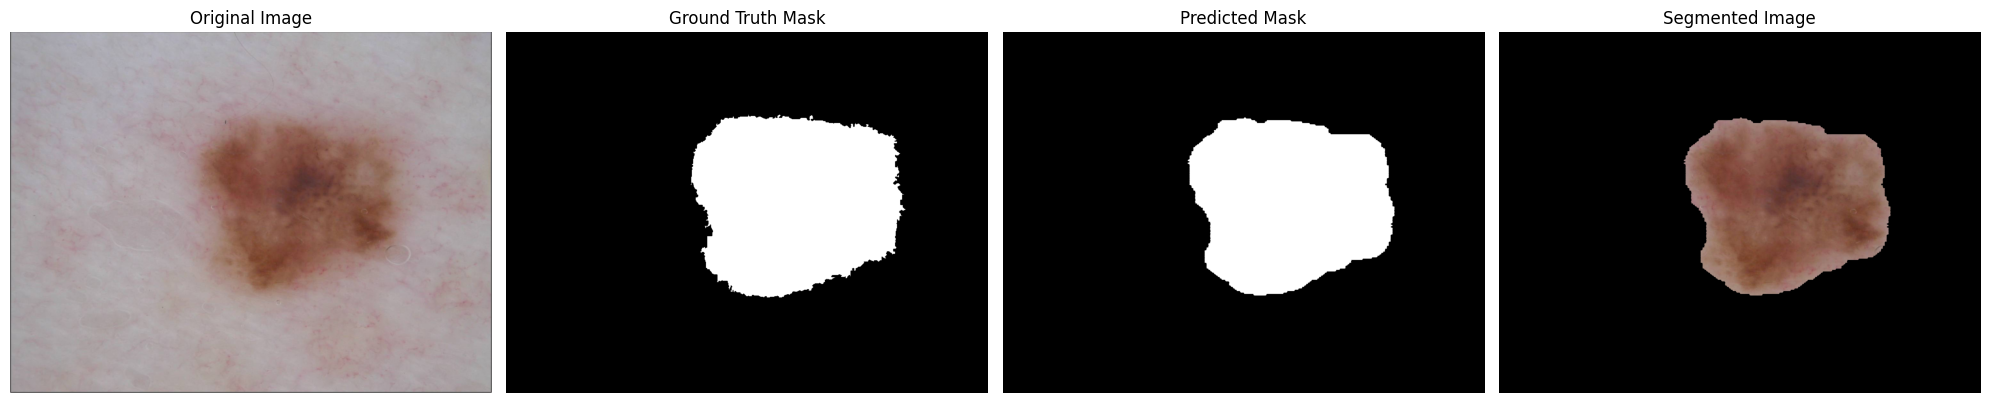

In [31]:
image_path = 'ISIC2018_Task1-2_Training_Input/ISIC_0000023.jpg'  # Replace with actual image path
mask_path = 'ISIC2018_Task1_Training_GroundTruth/ISIC_0000023_segmentation.png'  # Replace with actual mask path
segment_image(model, image_path, mask_path)